<a href="https://colab.research.google.com/github/jn19392/Goertzel/blob/master/Image_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy import stats
import seaborn as sns
import PIL
from PIL import Image

In [ ]:
file_path2 = '/content/drive/MyDrive/Smart_Meters/house_1_apps/Fridge.dat'
file_path = '/content/drive/MyDrive/Smart_Meters/house_5_apps/TV.dat'
file_path_aggregate = '/content/drive/MyDrive/Smart_Meters/house_5_apps/Agg.dat'

In [40]:
def NILMHeatmapMulti(Agg_file, App_file, App_file2, App, start, stop):

  table = pd.read_table(App_file,sep="\s+",names=['t','PR'])
  table2 = pd.read_table(App_file2,sep="\s+",names=['t','PR'])
  table_agg = pd.read_table(Agg_file ,sep="\s+",names=['t','PR']) # Read Files into tables
  
  data = table.to_numpy()
  data2 = table2.to_numpy()
  data_agg = table_agg.to_numpy() # Change tables to NP arrays

  data[:,0] = data[:,0] - data_agg[:,0].min()
  data2[:,0] = data2[:,0] - data_agg[:,0].min()
  data_agg[:,0] = data_agg[:,0] - data_agg[:,0].min() # Standardising so all values are with respect to min value

  index = data[:,1]  > 10
  index2 = data2[:,1] > 10
  data = data[index]
  data2 = data2[index2]

  window_start = start * 86400
  window_stop = stop * 86400
  ind_agg = (data_agg[:,0] >= (window_start)) & (data_agg[:,0] < (window_stop)) 
  ind = (data[:,0] >= (window_start)) & (data[:,0] < (window_stop)) 
  ind2 = (data2[:,0] >= (window_start)) & (data2[:,0] < (window_stop)) # Obtaining values for specified windows 

  data_agg_test = data_agg[ind_agg] 
  data_test = data[ind]
  data_test2 = data2[ind2]

  
  if len(data_agg_test) < 1:
    print('No aggregated data ')
  else:

    m = stop-start

    for j in range(m):
      day_data = np.zeros(17280)
      day_data2 = np.zeros(17280)
      day_data_none = np.zeros(17280)
      day_data_agg = np.zeros(17280)
      counter = 0
      counter2 = 0
      counter_none = 0
      for i in range(17280):
        idx_agg = (data_agg_test[:,0] >= (window_start) + (j*86400) + (i*5)) & (data_agg_test[:,0] < (window_start) + (j*86400)+((i+1)*5))
        idx = (data_test[:,0] >= (window_start) +  (j*86400)+(i*5)) & (data_test[:,0] < (window_start) + (j*86400)+((i+1)*5))
        idx2 = (data_test2[:,0] >= (window_start) +  (j*86400)+(i*5)) & (data_test2[:,0] < (window_start) + (j*86400)+((i+1)*5))
        

        day_data_agg[i] = np.mean(data_agg_test[idx_agg,1])
        
        if np.isnan(np.mean(data_test[idx,1])) == True:
          day_data[i] = np.mean(data_agg_test[idx_agg,1])
          counter += 1

        else:
          day_data[i] = np.mean(data_agg_test[idx_agg,1]) - np.mean(data_test[idx,1])

        if np.isnan(np.mean(data_test2[idx2,1])) == True:
          day_data2[i] = np.mean(data_agg_test[idx_agg,1])
          counter2 += 1

        else:
          day_data2[i] = np.mean(data_agg_test[idx_agg,1]) - np.mean(data_test2[idx2,1])

        if (np.isnan(np.mean(data_test[idx,1])) == True) & (np.isnan(np.mean(data_test2[idx2,1])) == True):
          day_data_none[i]  = np.mean(data_agg_test[idx_agg,1])
          counter_none += 1

        else:
          day_data_none[i] = np.mean(data_agg_test[idx_agg,1]) - np.mean(data_test[idx,1]) - np.mean(data_test2[idx2,1])
  



      heatmap = np.transpose(day_data.reshape(24,720))
      heatmap2 = np.transpose(day_data2.reshape(24,720))
      heatmap_none = np.transpose(day_data_none.reshape(24,720))
      heatmap_agg = np.transpose(day_data_agg.reshape(24,720))

      i1 = np.isnan(heatmap) == False
      i2 = np.isnan(heatmap2) == False
      i_none = np.isnan(heatmap_none) == False
      i_agg = np.isnan(heatmap_agg) == False


      heatmap = (heatmap - np.mean(heatmap[i1]))/(np.std(heatmap[i1]))
      heatmap2 = (heatmap2 - np.mean(heatmap2[i2]))/(np.std(heatmap2[i2]))
      heatmap_none = (heatmap_none - np.mean(heatmap_none[i_none]))/(np.std(heatmap_none[i_none]))
      heatmap_agg = (heatmap_agg - np.mean(heatmap_agg[i_agg]))/(np.std(heatmap_agg[i_agg]))
      # print(heatmap_agg[i].max())
      # print(heatmap[i].max())

      if counter == 17280 & counter2 == 17280:
        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap_agg,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_None/5Day'+ str(start + j + 1))
        #plt.show()
        
      elif counter == 17280:
        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap_agg,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_No_1/5Day'+ str(start + j + 1))
        #plt.show()

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap2,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_None/5Day'+ str(start + j + 1))
        #plt.show()


      elif counter2 == 17280:
        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap_agg,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_No_2/5Day'+ str(start + j + 1))
        #plt.show()

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_None/5Day'+ str(start + j + 1))
        #plt.show()

      else:
        plt.figure
        #plt.title('Aggregated data for day ' + str(start + j + 1))
        #plt.xlabel('Hours')
        #plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap_agg,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_Agg/5Day'+ str(start + j + 1))
        #plt.show()

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_No_2/5Day'+ str(start + j + 1))
        #plt.show()

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap2,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_No_1/5Day'+ str(start + j + 1))
        #plt.show()

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('on')
        sns.heatmap(heatmap_none,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = True)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/Multiclass_test/Class_None/5Day'+ str(start + j + 1))
        #plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


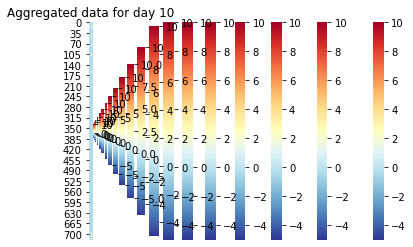

In [46]:
s = 0
e = 10

for i in range(1):
  NILMHeatmapMulti(file_path_aggregate, file_path,file_path2, '', s,e)
  s += 10
  e += 10

In [ ]:
NILMHeatmapMulti(file_path_aggregate, file_path, file_path2, 'dishwasher', 368,370)

No aggregated data 


In [ ]:
  table1 = pd.read_table(file_path,sep="\s+",names=['t','PR'])
  table_agg1 = pd.read_table(file_path_aggregate ,sep="\s+",names=['t','PR'])
  
  data1 = table1.to_numpy()
  data_agg1 = table_agg1.to_numpy()

  data1[:,0] = data1[:,0] - data_agg1[:,0].min()
  data_agg1[:,0] = data_agg1[:,0] - data_agg1[:,0].min()

In [47]:
  Agg_days = (data_agg1[-1,0] - data_agg1[0,0]) / (60*60*24)     #Total Num of days for agg
  App_days = (data1[-1,0] - data1[0,0]) / (60 * 60 * 24)     #Total Num of days for app
  Day_start = (data1[0,0] - data_agg1[0,0]) / (60 * 60 *24)     #Day that appliance data starts
  Total_days = Agg_days - Day_start # Days that are tehrefore available
  Train_days = Total_days * 0.8 # No of Training Days
  Val_days = Total_days * 0.2 # No of Validation Days
  print(Agg_days)
  print(App_days)
  print(Day_start)
  print(Total_days)
  print(Train_days)
  print(Val_days)

137.06152777777777
137.06417824074074
-16250.683148148148
16387.744675925926
13110.19574074074
3277.548935185185


In [48]:
NILMHeatmap(file_path_aggregate, file_path, 'TV', 0,125)

NameError: ignored

In [ ]:
def NILMHeatmap(Agg_file, App_file, App, start, stop):

  table = pd.read_table(App_file,sep="\s+",names=['t','PR'])
  table_agg = pd.read_table(Agg_file ,sep="\s+",names=['t','PR'])
  
  data = table.to_numpy()
  data_agg = table_agg.to_numpy()

  data[:,0] = data[:,0] - data_agg[:,0].min()
  data_agg[:,0] = data_agg[:,0] - data_agg[:,0].min()

  index = data[:,1]  > 10
  data = data[index]
  # print(data[:,1])

  # data[:,1] = stats.zscore(data[:,1])
  # data_agg[:,1] = stats.zscore(data_agg[:,1])

  # print(data_agg[:,1].max())
  # print(data[:,1].max())


  # z_score = stats.zscore(data[:,1])
  # ind = z_score < 4
  # data = data[ind]

  # z_score_agg = stats.zscore(data_agg[:,1])
  # ind_agg = z_score_agg < 4
  # data_agg = data_agg[ind_agg]

  window_start = start * 86400
  window_stop = stop * 86400
  ind_agg = (data_agg[:,0] >= (window_start)) & (data_agg[:,0] < (window_stop)) 
  ind = (data[:,0] >= (window_start)) & (data[:,0] < (window_stop)) 

  data_agg_test = data_agg[ind_agg] 
  data_test = data[ind]

  
  if len(data_agg_test) < 1:
    print('No aggregated data ')
  else:

  # m = round((data_agg_test[:,0].max() - data_agg_test[:,0].min())/86400)
 
  # print(data_agg_test[:,0].max())
  # print(data_agg_test[:,0].min())
    m = stop-start

    for j in range(m):
      day_data = np.zeros(17280)
      day_data_agg = np.zeros(17280)
      counter = 0
      for i in range(17280):
        idx_agg = (data_agg_test[:,0] >= (window_start) + (j*86400) + (i*5)) & (data_agg_test[:,0] < (window_start) + (j*86400)+((i+1)*5))
        idx = (data_test[:,0] >= (window_start) +  (j*86400)+(i*5)) & (data_test[:,0] < (window_start) + (j*86400)+((i+1)*5))
        

        day_data_agg[i] = np.mean(data_agg_test[idx_agg,1])
        
        if np.isnan(np.mean(data_test[idx,1])) == True:
          day_data[i] = np.mean(data_agg_test[idx_agg,1])
          counter += 1

        else:
          day_data[i] = np.mean(data_agg_test[idx_agg,1]) - np.mean(data_test[idx,1])


      heatmap = np.transpose(day_data.reshape(24,720))
      heatmap_agg = np.transpose(day_data_agg.reshape(24,720))

      i = np.isnan(heatmap) == False
      i_agg = np.isnan(heatmap_agg) == False


      heatmap = (heatmap - np.mean(heatmap[i]))/(np.std(heatmap[i]))
      heatmap_agg = (heatmap_agg - np.mean(heatmap_agg[i_agg]))/(np.std(heatmap_agg[i_agg]))
      # print(heatmap_agg[i].max())
      # print(heatmap[i].max())

      if counter == 17280:
        
        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.axis('off')
        sns.heatmap(heatmap_agg,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar = False)
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/TV_test/Class_No_App-TV/5Day'+ str(start + j + 1))
        #plt.show()

      else:

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1))

        plt.axis('off')
        sns.heatmap(heatmap_agg,vmin=-5,vmax=10,cmap='RdYlBu_r',cbar= False)
        plt.xlabel('Hours')
        plt.ylabel('Seconds')
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/TV_test/Class_App-TV/5Day'+ str(start + j + 1))        
        #plt.show()

        plt.figure
        plt.title('Aggregated data for day ' + str(start + j + 1) + ' minus the ' + App)

       # plt.axis('off')
        sns.heatmap(heatmap,vmin=-5,vmax=10,cmap='RdYlBu_r', cbar=False)
        plt.xlabel("Hours")
        plt.ylabel("Seconds")
        plt.savefig('/content/drive/MyDrive/Smart_Meters/Final_sets/TV_test/Class_No_App-TV/5Day'+ str(start + j + 1))
        #plt.show()

In [45]:
s = 100
e = 110

for i in range(3):
  NILMHeatmap(file_path_aggregate, file_path, 'TV', s,e)
  s += 10
  e += 10

NameError: ignored

In [ ]:
a = np.random.rand(10)*10
print(a)
a = (a - np.mean(a))/np.std(a)

print(a)

In [ ]:
TimeSeries(file_path_aggregate, file_path, 'Refrigerator', 124,125)

def TimeSeries(Agg_file, App_file, App, start, stop):
  table = pd.read_table(App_file,sep="\s+",names=['t','PR'])
  table_agg = pd.read_table(Agg_file ,sep="\s+",names=['t','PR'])
  
  data = table.to_numpy()
  data_agg = table_agg.to_numpy()

  data[:,0] = data[:,0] - data_agg[:,0].min()
  data_agg[:,0] = data_agg[:,0] - data_agg[:,0].min()

  window_start = start * 86400
  window_stop = stop * 86400
  ind_agg = (data_agg[:,0] >= (window_start)) & (data_agg[:,0] < (window_stop)) 
  ind = (data[:,0] >= (window_start)) & (data[:,0] < (window_stop)) 

  data_agg_test = data_agg[ind_agg] 
  data_test = data[ind]


  if len(data_agg_test) < 1:
    print('No aggregated data ')
  else:
    m = stop -start
    for j in range(m):
      ind_agg = (data_agg_test[:,0] >= (window_start) + (j*86400)) & (data_agg_test[:,0] < (window_start) + ((j+1)*86400))
      ind = (data_test[:,0] >= (window_start) + (j*86400)) & (data_test[:,0] < (window_start) + ((j+1)*86400))
      
      val_agg = data_agg_test[ind_agg]
      val_agg[:,0] = val_agg[:,0] - val_agg[0,0]
      val = data_test[ind]
      val[:,0] = val[:,0] - val[0,0]
      plt.figure
      plt.title('Time series representation of UK Dale dataset')
      plt.plot(val_agg[:,0],val_agg[:,1],label = 'Aggregated Data')
      plt.plot(val[:,0],val[:,1], label = App + ' Data')
      plt.xlabel('Time (s)')
      plt.ylabel('Power reading (W)')
      plt.ylim(0,2000)
      plt.legend()
      plt.savefig('/content/drive/MyDrive/Smart_Meters/Report Image/TS' + App + str(start + j + 1) + '.pdf')
      plt.show()
      print(val_agg[-1,0])


In [ ]:
table = pd.read_table(file_path,sep="\s+",names=['t','PR'])
table_agg = pd.read_table(file_path_aggregate ,sep="\s+",names=['t','PR'])
  
data = table.to_numpy()
data_agg = table_agg.to_numpy()

data[:,0] = data[:,0] - data_agg[:,0].min()
data_agg[:,0] = data_agg[:,0] - data_agg[:,0].min()

data_agg[:,0].min()-data[:,0].min() / -86400


In [ ]:
def HeatmapAgg(start, stop):
  window_start = start *86400                                                          # Frame start 
  window_stop = stop * 86400   # Frame end
  
  ind_agg = (data_agg[:,0] >= (window_start)) & (data_agg[:,0] < (window_stop)) 
  data_agg_test = data_agg[ind_agg]  
  # print(data_agg_test[0])                                            # Separating data into smaller pieces

  m = round((data_agg_test[:,0].max() - data_agg_test[:,0].min())/86400)

  #day_data = np.zeros(17280)

  for j in range(m):
    day_data = np.zeros(17280)
  
    for i in range(17280):
      id = (data_agg_test[:,0] >= (window_start) + (j*86400)+(i*5)) & (data_agg_test[:,0] < (window_start) + (j*86400)+((i+1)*5))
      day_data[i] = np.mean(data_agg_test[id,1])

    heatmap = np.transpose(day_data.reshape(24,720))
    # print(heatmap)
    plt.figure
    plt.title('Aggregated data for day ' + str(start + j + 1))
    plt.xlabel('Hours')
    plt.ylabel('Seconds')
    sns.heatmap(heatmap,cmap = 'Greys_r')
    plt.show()

In [42]:
table_agg1 = pd.read_table(file_path_aggregate ,sep="\s+",names=['t','PR'])

data1 = table1.to_numpy()
data_agg1 = table_agg1.to_numpy()

data1[:,0] = data1[:,0] - data_agg1[:,0].min()
data_agg1[:,0] = data_agg1[:,0] - data_agg1[:,0].min()

In [ ]:
def Heatmap_noappliance(start, stop):

  window_start = start * 86400
  window_stop = stop * 86400
  ind_agg = (data_agg[:,0] >= (window_start)) & (data_agg[:,0] < (window_stop)) 
  ind = (data[:,0] >= (window_start)) & (data[:,0] < (window_stop)) 

  data_agg_test = data_agg[ind_agg]
  #print(data_agg_test[0])
 
  data_test = data[ind]
  #print(data_test[0])


  m = round((data_agg_test[:,0].max() - data_agg_test[:,0].min())/86400)

  #day_data = np.zeros(17280)

  for j in range(m):
    day_data = np.zeros(17280)

  
    for i in range(17280):
      idx_agg = (data_agg_test[:,0] >= (window_start) + (j*86400) + (i*5)) & (data_agg_test[:,0] < (window_start) + (j*86400)+((i+1)*5))
      idx = (data_test[:,0] >= (window_start) +  (j*86400)+(i*5)) & (data_test[:,0] < (window_start) + (j*86400)+((i+1)*5))

      if np.isnan(np.mean(data_test[idx,1])) == True:
         day_data[i] = np.mean(data_agg_test[idx_agg,1])

     #    print(data_agg_test[idx_agg,1])
      else:
        day_data[i] = np.mean(data_agg_test[idx_agg,1]) - np.mean(data_test[idx,1])
        # print(np.mean(data_test[idx,1]))




    heatmap = np.transpose(day_data.reshape(24,720))
    # print(heatmap)

    plt.figure
    plt.title('Aggregated data for day ' + str(start + j + 1) + ' minus the ' + Appliance )
    plt.xlabel('Hours')
    plt.ylabel('Seconds')
    sns.heatmap(heatmap,cmap = 'Greys_r')
    plt.show()


In [43]:
HeatmapAgg(35,36)
Heatmap_noappliance(40,41)

NameError: ignored

In [ ]:
# Reading files into dataframes
table = pd.read_table(file_path,sep="\s+",names=['t','PR'])
table_agg = pd.read_table(file_path_aggregate ,sep="\s+",names=['t','PR'])


In [ ]:
# Transfering data into numpy arrays
data = table.to_numpy()
data_agg = table_agg.to_numpy()


In [ ]:
# Statistical data of the appliance and aggregated data sets
max_appliance = max(data[:,1])
min_appliance = min(data[:,1])
range_appliance = max_appliance - min_appliance

max_agg = max(data_agg[:,1])
min_agg = min(data_agg[:,1])
range_agg = max_appliance - min_appliance


In [ ]:
# Printing statistical values

print(max_appliance)
print(min_appliance)
print(range_appliance)

print(max_agg)
print(min_agg)
print(range_agg)

1664
0
1664
9644
347
1664


In [ ]:
print(np.mean(data_agg[:,1]))

690.7531860057932


In [ ]:
# Finding the average and maximum time gap between data readings
gap = []
for i in range(len(data_agg[:,0])-1):
  a = data_agg[i+1,0]-data_agg[i,0]
  gap.append(a)

print(max(gap))
print(np.mean(gap))

402777
6.716644546537349


In [ ]:
# Recalibrating data to start from 0
data[:,0] = data[:,0] - data[0,0]
data_agg[:,0] = data_agg[:,0] - data_agg[0,0]

In [ ]:
# An attempt to smooth data

z_score = stats.zscore(data[:,1])
ind = z_score < 3
data = data[ind]

z_score_agg = stats.zscore(data_agg[:,1])
ind_agg = z_score_agg < 2
data_agg = data_agg[ind_agg]




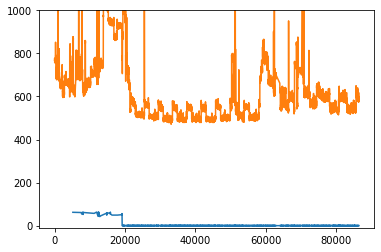

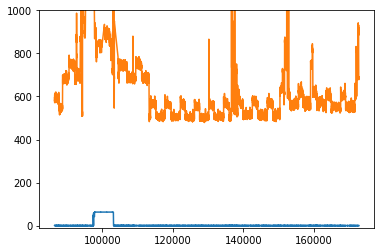

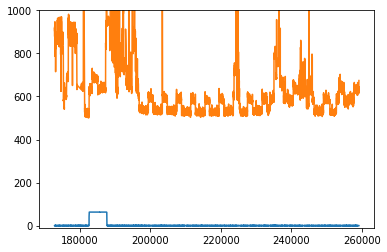

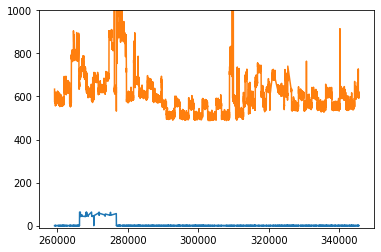

In [ ]:
# 1st Heatmap attempt 

n = 1
secs = 60 * 60 * 24 * n
total_time = data[-1,0] - data[0,0]
m =  total_time / secs
m = int(m)


for i in range(4):
  idx = (data[:,0] >= i*secs) & (data[:,0] < (i+1)*secs)
  idx_agg = (data_agg[:,0] >= i*secs) & (data_agg[:,0] < (i+1)*secs)
  plt.figure()
  plt.plot(data[idx,0],data[idx,1])
  plt.plot(data_agg[idx_agg,0],data_agg[idx_agg,1])
  plt.ylim([-10,1000])
  plt.show()
  

In [ ]:
day = 60 * 60 * 24
hour = 60 * 60
minute = 60

# Chosen time frame ########
TimeFrame = 30 * day
Window_Y = 60 * minute
Window_X = 1 * day
############################

total_time = data[-1,0] - data[0,0]
m =  total_time / TimeFrame
m = int(m)

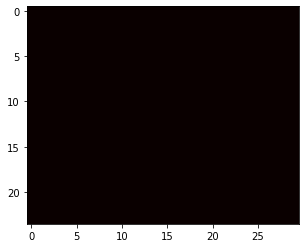

In [ ]:
X_bins = int(TimeFrame / Window_X)
Y_bins = int(Window_X / Window_Y)

for k in range(1):
  matrix = np.zeros((Y_bins,X_bins))
  for i in range(X_bins):
    for j in range(Y_bins):
      idx = (data_agg[:,0] >= (k*TimeFrame)+(i*Window_X)+(j*Window_Y) & (data_agg[:,0] < (k*TimeFrame)+(i*Window_X)+((j*+1)*Window_Y)))
      val = np.mean(data_agg[idx,1])
      matrix[j,i] = val
  plt.imshow(matrix, cmap='hot', interpolation='nearest')
  plt.show()



yes


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


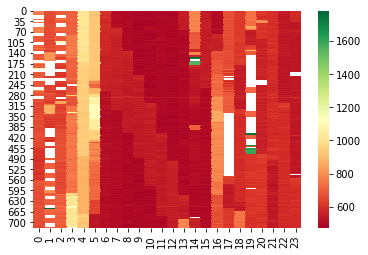

In [ ]:
window_start = 0
window_stop = 1
ind_agg = (data_agg[:,0] >= (window_start*86400)) & (data_agg[:,0] < (window_stop*86400)) 
#ind = (data[:,0] >= (window_start*86400)) & (data[:,0] < (window_stop*86400)) 

data_agg_test = data_agg[ind_agg]
#data_test = data[ind]

m = round(data_agg_test[-1,0]/86400)


day_data = np.zeros(17280)

for j in range(m):
  day_data = np.zeros(17280)
  print('yes')
  
  for i in range(17280):
    id = (data_agg_test[:,0] >= (j*86400)+(i*5)) & (data_agg_test[:,0] < (j*86400)+((i+1)*5))
    day_data[i] = np.mean(data_agg_test[id,1])

  heatmap = np.transpose(day_data.reshape(24,720))
  plt.figure
  sns.heatmap(heatmap,cmap = 'RdYlGn')
  plt.show()



In [ ]:
window_start = 0
window_stop = 1
ind_agg = (data_agg[:,0] >= (window_start*86400)) & (data_agg[:,0] < (window_stop*86400)) 
ind = (data[:,0] >= (window_start*86400)) & (data[:,0] < (window_stop*86400)) 

data_agg_test = data_agg[ind_agg]
data_test = data[ind]

m = round(data_agg_test[-1,0]/86400)


day_data = np.zeros(17280)

for j in range(m):
  day_data = np.zeros(17280)
  print('yes')
  
  for i in range(17280):
    idx_agg = (data_agg_test[:,0] >= (j*86400)+(i*5)) & (data_agg_test[:,0] < (j*86400)+((i+1)*5))
    idx = (data_test[:,0] >= (j*86400)+(i*5)) & (data_test[:,0] < (j*86400)+((i+1)*5))

    day_data[i] = np.mean(data_agg_test[idx_agg,1]) - np.mean(data_test[idx,1])

  heatmap = np.transpose(day_data.reshape(24,720))
  plt.figure
  sns.heatmap(heatmap,cmap = 'RdYlGn')
  plt.show()



In [ ]:
# day_data.shape
heatmap = np.transpose(day_data.reshape(24,720))
day_data
heatmap.shape
print(day_data[0:10])
print(heatmap[0:10,0])

In [ ]:
plt.figure
sns.heatmap(heatmap,cmap = 'RdYlGn')
plt.show()